<a href="https://colab.research.google.com/github/sam02425/StoreLineDetection/blob/main/train_yolov8_object_detection_on_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Mar  3 07:51:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **03.01.2024** with version **YOLOv8.0.196**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [3]:
# Pip install method (recommended)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/201.2 GB disk)


In [4]:
# Git clone method (for development)

# %cd {HOME}
# !git clone github.com/ultralytics/ultralytics
# %cd {HOME}/ultralytics
# !pip install -e .

# from IPython import display
# display.clear_output()

# import ultralytics
# ultralytics.checks()

In [5]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started. Read more about CLI in [Ultralytics YOLO Docs](https://docs.ultralytics.com/usage/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

## Inference with Pre-trained COCO Model

### 💻 CLI

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

In [6]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

/content
100% 6.23M/6.23M [00:00<00:00, 333MB/s]
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

100% 104k/104k [00:00<00:00, 88.8MB/s]
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 108.7ms
Speed: 14.0ms preprocess, 108.7ms inference, 1270.0ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


/content


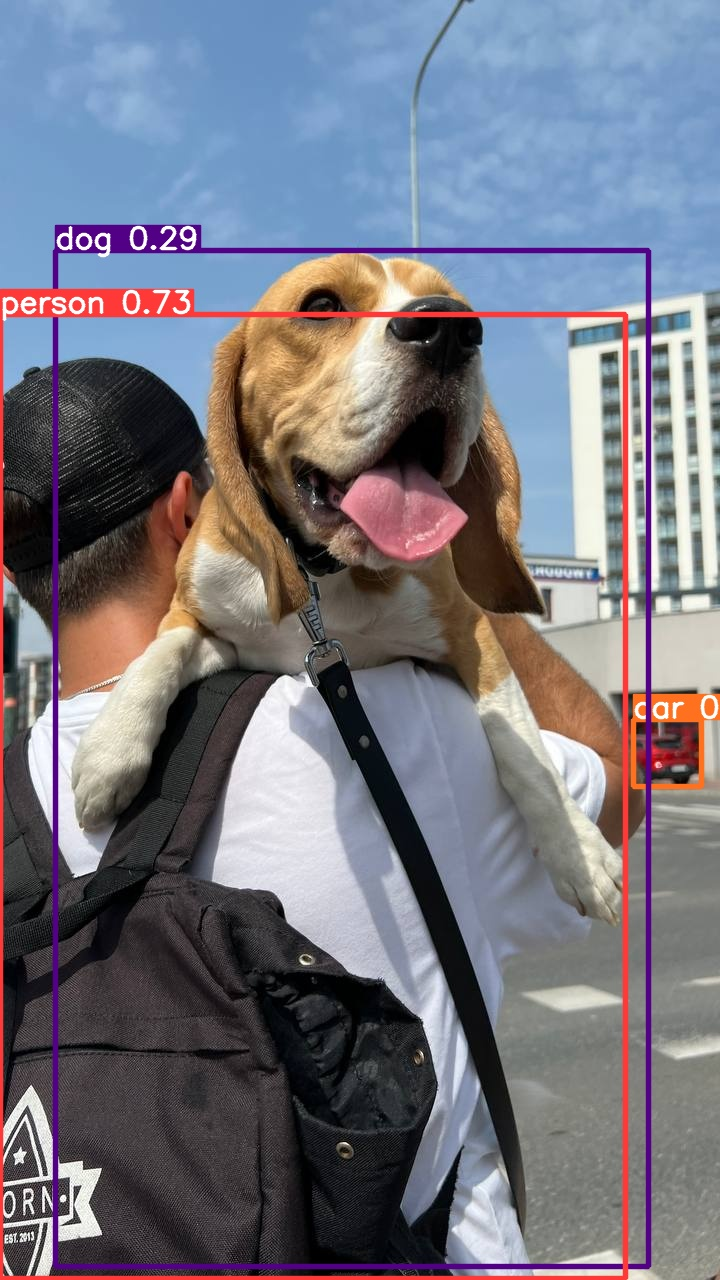

In [7]:
%cd {HOME}
Image(filename='runs/detect/predict/dog.jpeg', height=600)

### 🐍 Python SDK

The simplest way of simply using YOLOv8 directly in a Python environment.

In [8]:
model = YOLO(f'{HOME}/yolov8n.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)


Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 100.5ms
Speed: 3.3ms preprocess, 100.5ms inference, 609.0ms postprocess per image at shape (1, 3, 640, 384)


In [9]:
results[0].boxes.xyxy

tensor([[   0.0000,  314.4717,  625.0754, 1278.1946],
        [  55.1731,  250.0220,  648.1080, 1266.2720],
        [ 633.2291,  719.5391,  701.0538,  786.0336]], device='cuda:0')

In [10]:
results[0].boxes.conf

tensor([0.7271, 0.2907, 0.2846], device='cuda:0')

In [11]:
results[0].boxes.cls

tensor([ 0., 16.,  2.], device='cuda:0')

In [13]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="mtJUPQXdun3mtgZUKOK5")
project = rf.workspace("lamar-university-venef").project("line-detection-ak64k")
version = project.version(1)
dataset = version.download("yolov8")


mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to line-detection-1 in yolov8:: 100%|██████████| 182/182 [00:00<00:00, 6288.36it/s]


## Custom Training

In [14]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=50 imgsz=90 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 271MB/s]
New https://pypi.org/project/ultralytics/8.1.20 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/datasets/line-detection-1/data.yaml, epochs=50, patience=50, batch=16, imgsz=90, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_

In [15]:
!ls {HOME}/runs/detect/train/

args.yaml					   P_curve.png	       train_batch161.jpg
confusion_matrix_normalized.png			   PR_curve.png        train_batch162.jpg
confusion_matrix.png				   R_curve.png	       train_batch1.jpg
events.out.tfevents.1709452397.99d9502cd5da.817.0  results.csv	       train_batch2.jpg
F1_curve.png					   results.png	       val_batch0_labels.jpg
labels_correlogram.jpg				   train_batch0.jpg    val_batch0_pred.jpg
labels.jpg					   train_batch160.jpg  weights


/content


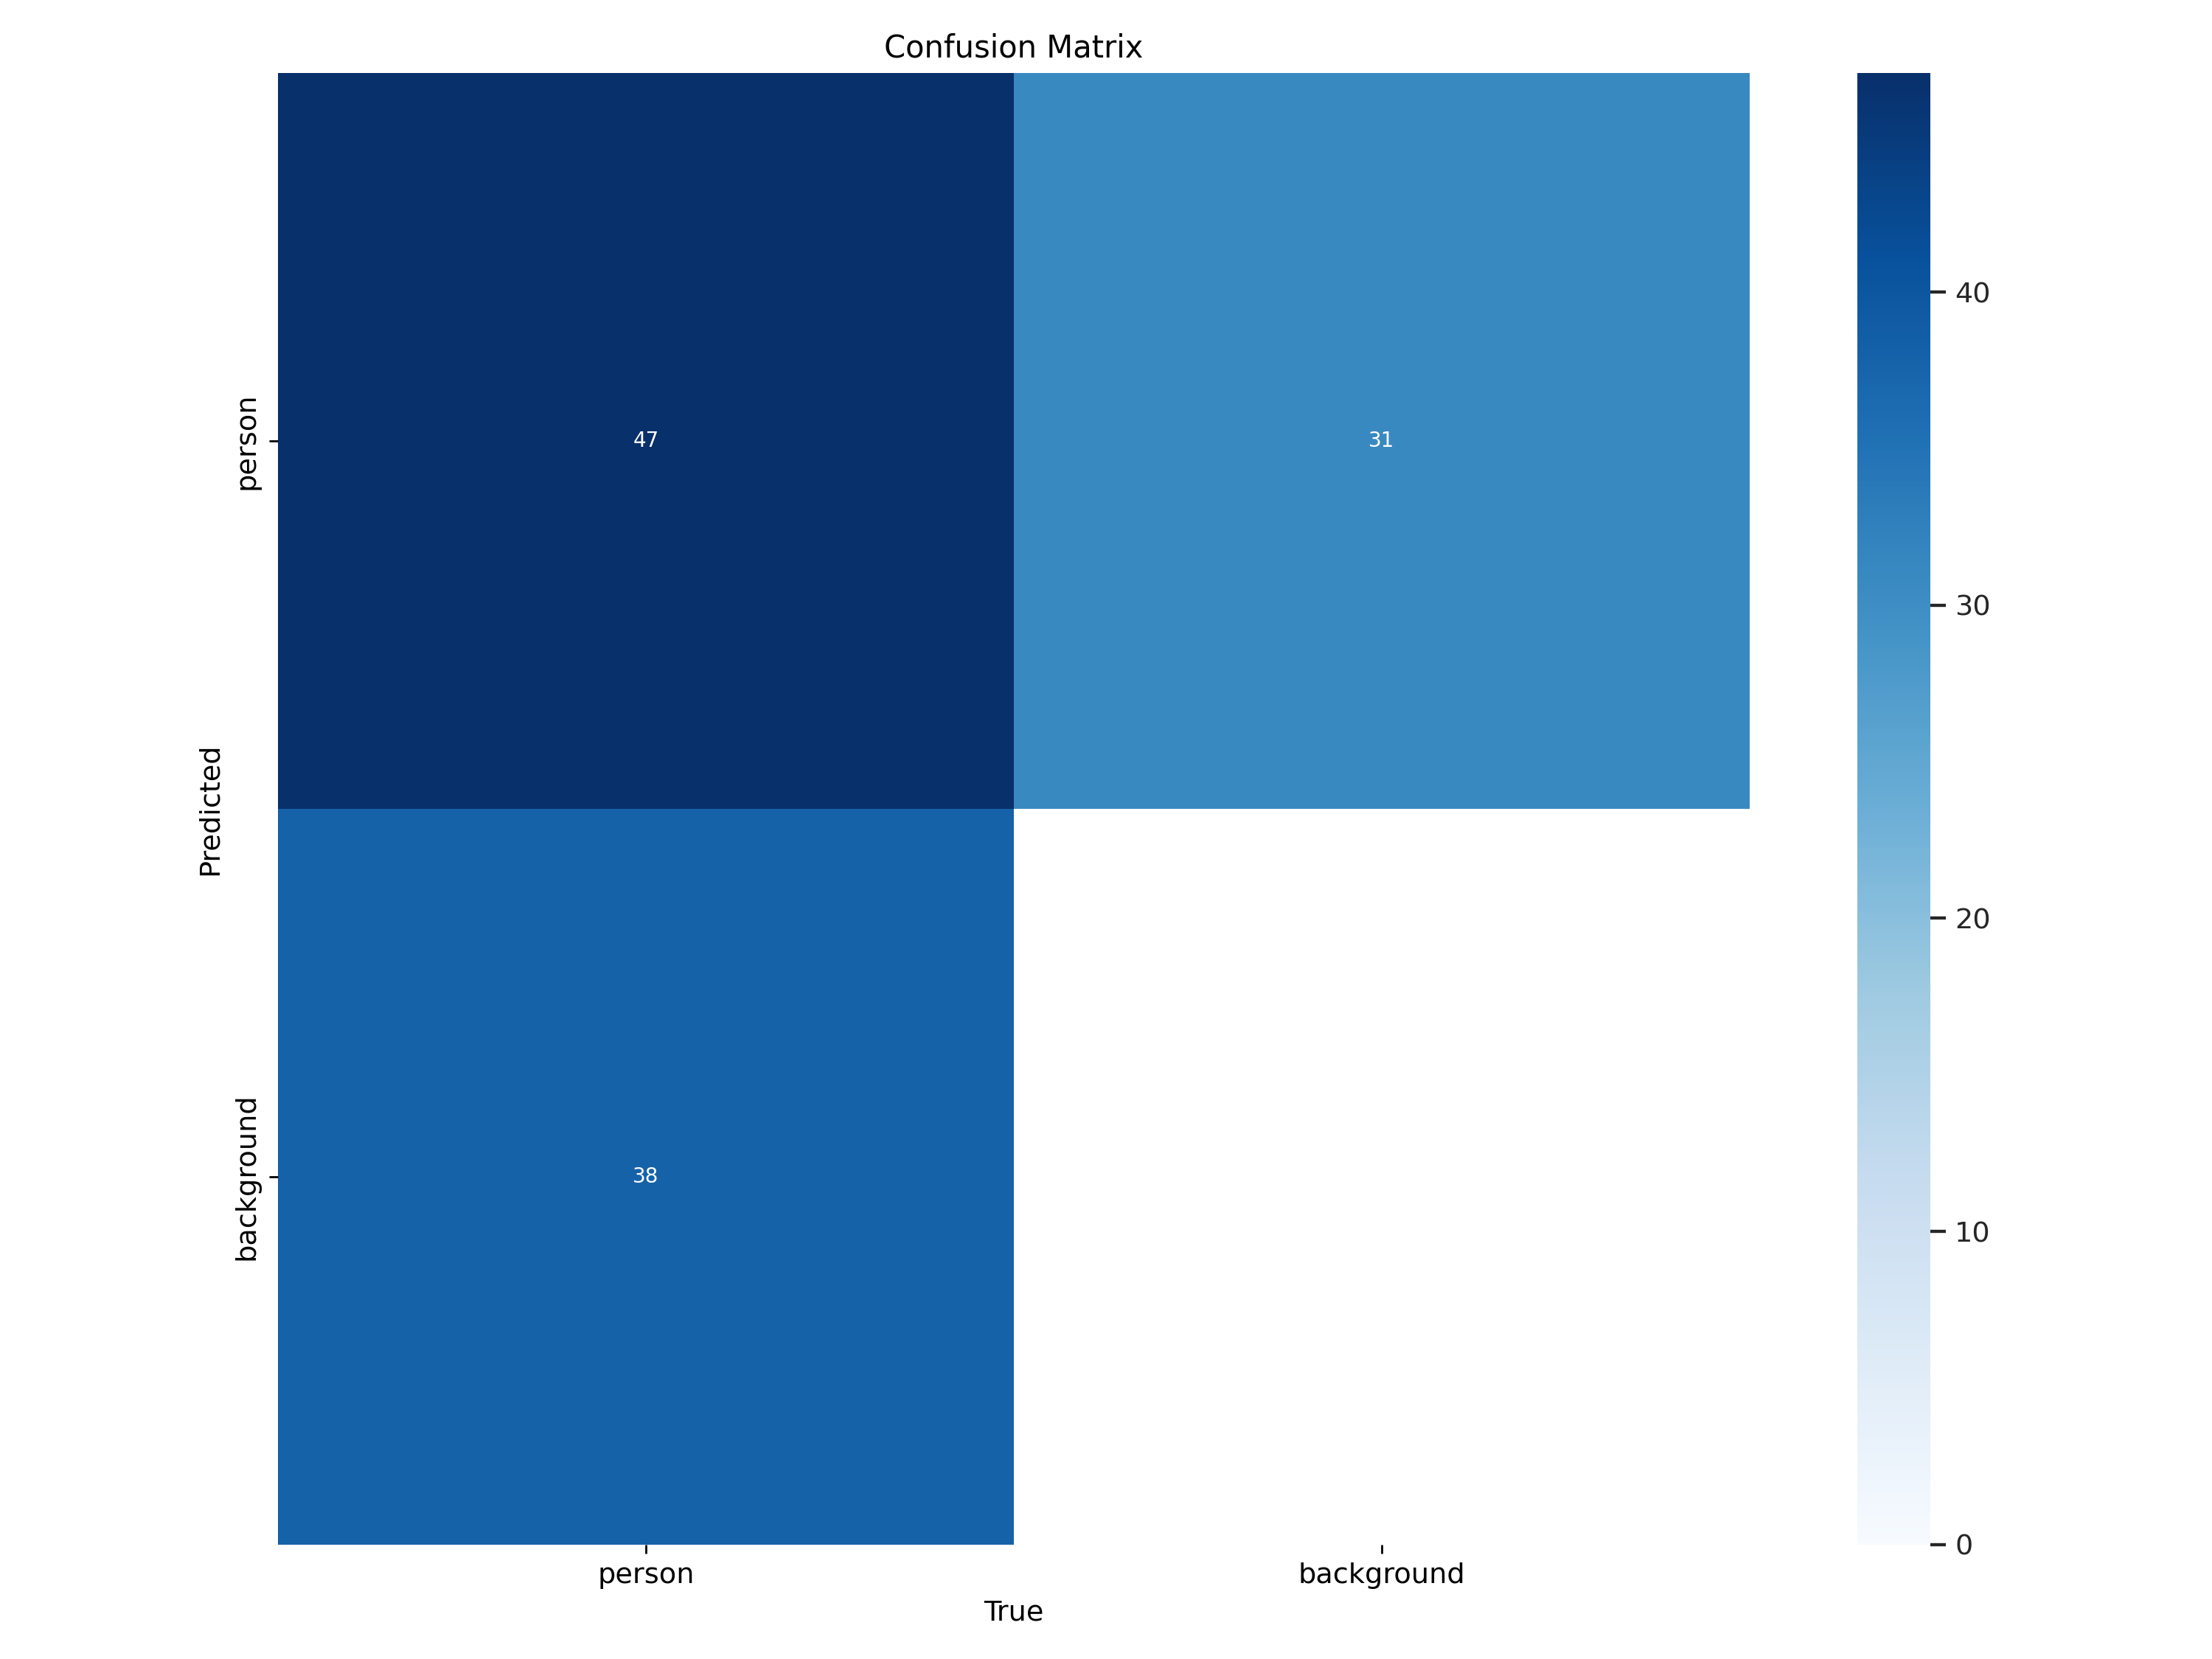

In [16]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


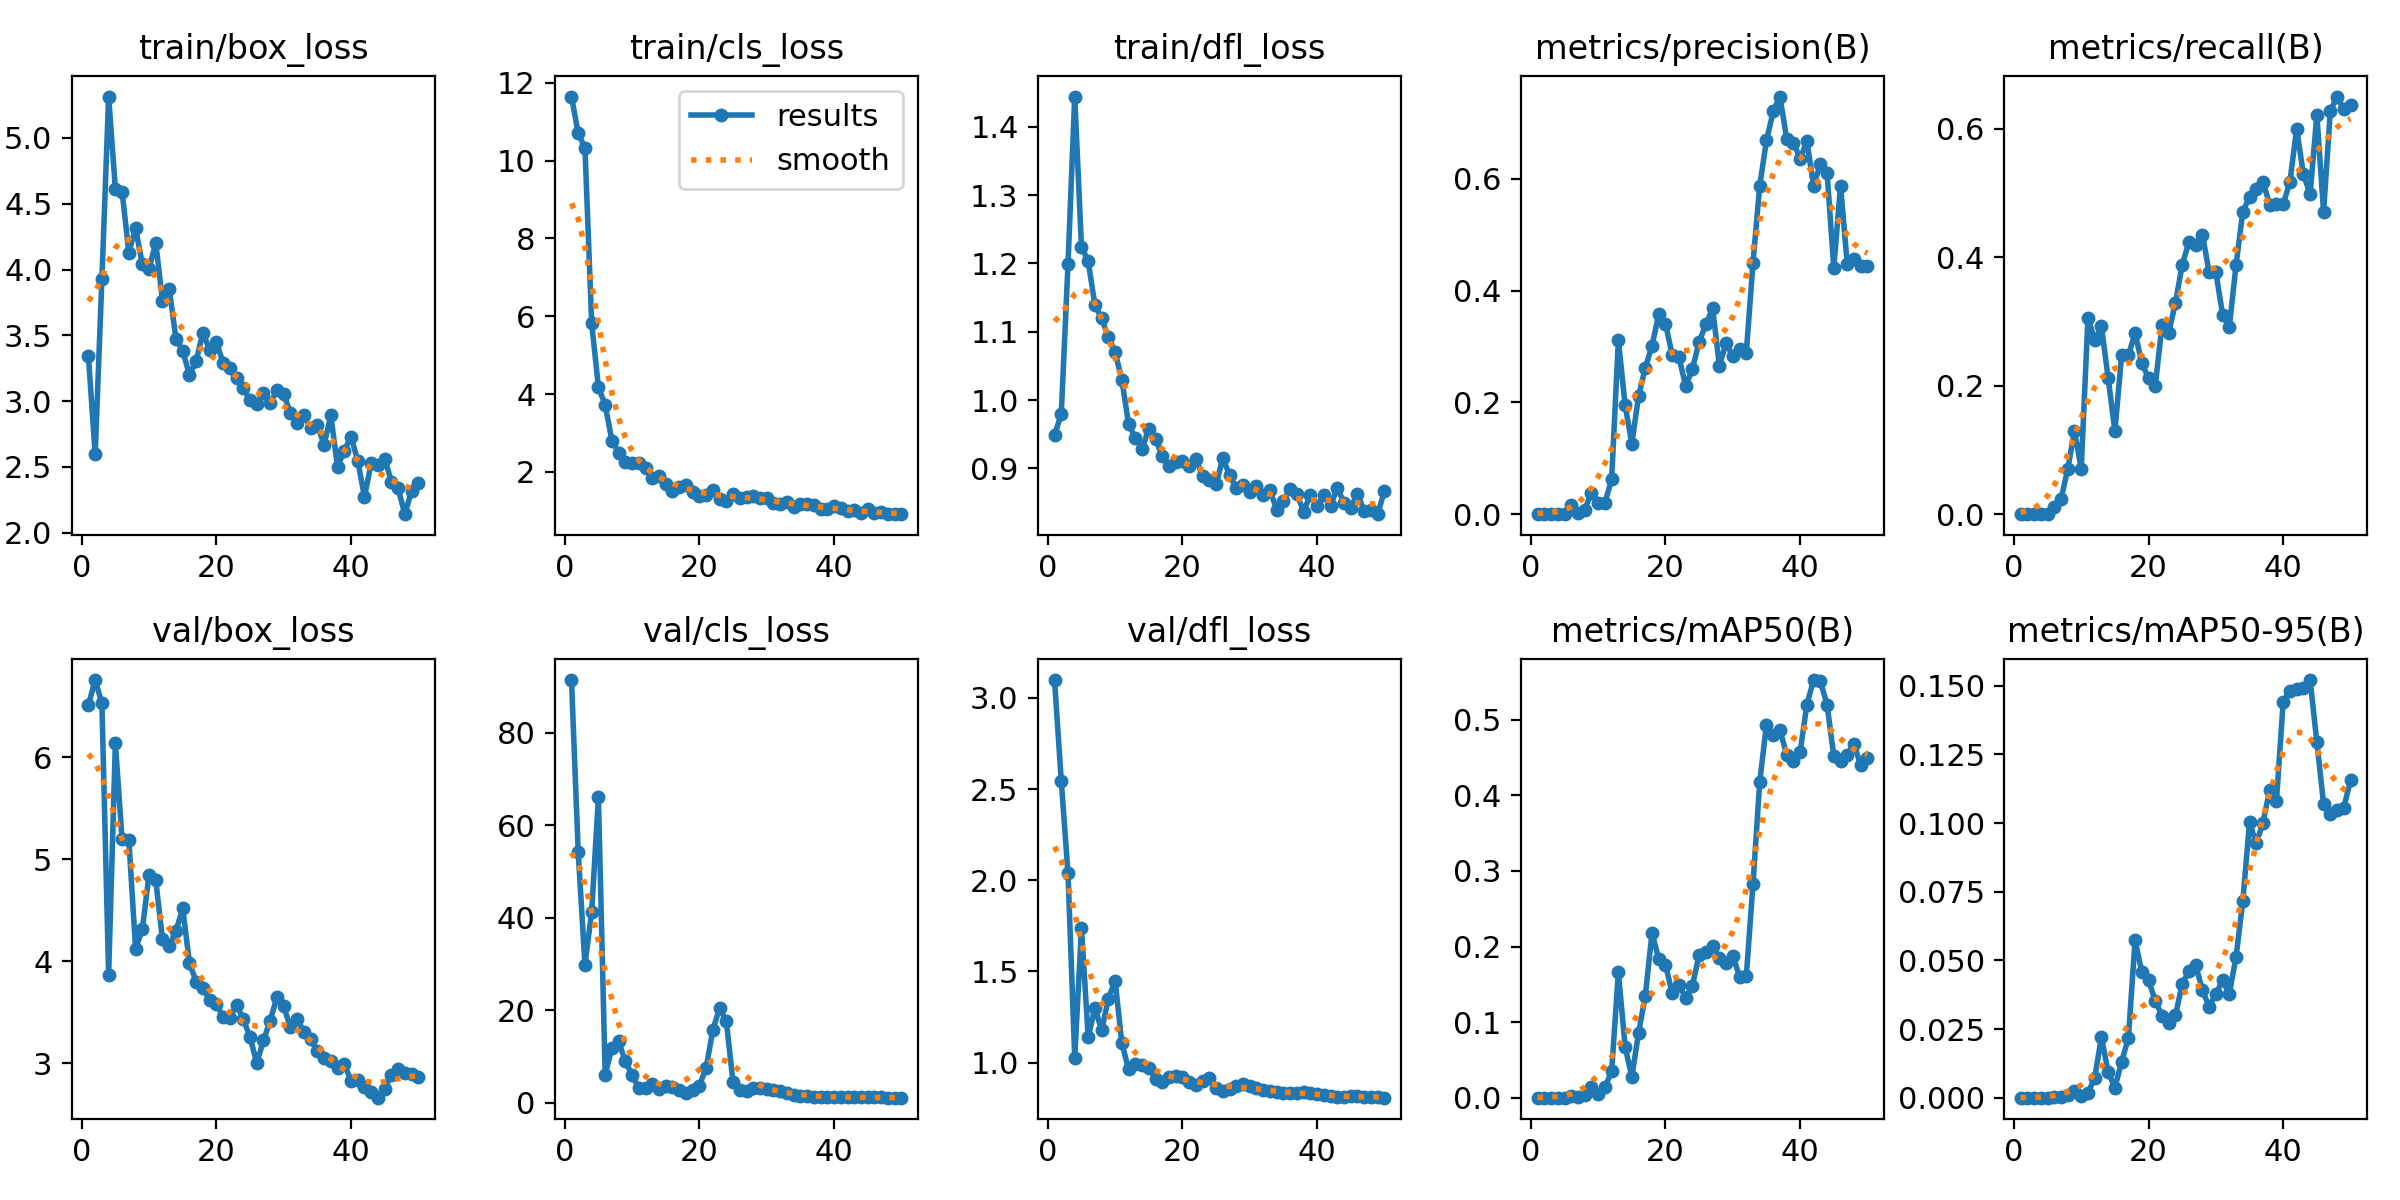

In [17]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


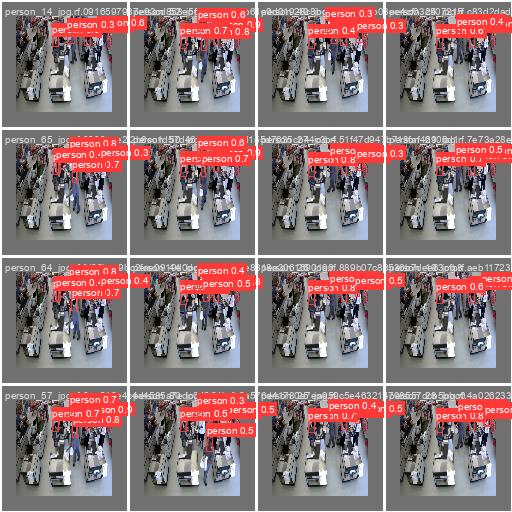

In [18]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [19]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/line-detection-1/valid/labels.cache... 17 images, 0 backgrounds, 0 corrupt: 100% 17/17 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:02<00:00,  1.07s/it]
                   all         17         85      0.618      0.529      0.552      0.149
Speed: 0.3ms preprocess, 76.1ms inference, 0.0ms loss, 41.5ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with Custom Model

In [20]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/9 /content/datasets/line-detection-1/test/images/person_13_jpg.rf.6303af68cdb3b2fd187461ec251fd65b.jpg: 96x96 4 persons, 9.9ms
image 2/9 /content/datasets/line-detection-1/test/images/person_18_jpg.rf.57d6f0aa413e4c0c4134f178be807aa8.jpg: 96x96 4 persons, 7.0ms
image 3/9 /content/datasets/line-detection-1/test/images/person_31_jpg.rf.4025a4f88682ce55add3e2321f8f4cd6.jpg: 96x96 4 persons, 6.7ms
image 4/9 /content/datasets/line-detection-1/test/images/person_36_jpg.rf.187cffd4ddd1168e60351936f3460a2c.jpg: 96x96 5 persons, 7.5ms
image 5/9 /content/datasets/line-detection-1/test/images/person_43_jpg.rf.67d6fa50d6031212bd69e8f81161105a.jpg: 96x96 5 persons, 6.7ms
image 6/9 /content/datasets/line-detection-1/test/images/person_49_jpg.rf.1e94693d71d2ca31a0ff3e7f694c99

**NOTE:** Let's take a look at few results.

In [21]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict3/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

# Deploy Your Model to the Edge

In addition to using the Roboflow hosted API for deployment, you can use [Roboflow Inference](https://inference.roboflow.com), an open source inference solution that has powered millions of API calls in production environments. Inference works with CPU and GPU, giving you immediate access to a range of devices, from the NVIDIA Jetson to TRT-compatible devices to ARM CPU devices.

With Roboflow Inference, you can self-host and deploy your model on-device. You can deploy applications using the [Inference Docker containers](https://inference.roboflow.com/quickstart/docker/) or the pip package.

For example, to install Inference on a device with an NVIDIA GPU, we can use:

```
docker pull roboflow/roboflow-inference-server-gpu
```

Then we can run inference via HTTP:

```python
import requests

workspace_id = ""
model_id = ""
image_url = ""
confidence = 0.75
api_key = ""

infer_payload = {
    "image": {
        "type": "url",
        "value": image_url,
    },
    "confidence": confidence,
    "iou_threshold": iou_thresh,
    "api_key": api_key,
}
res = requests.post(
    f"http://localhost:9001/{workspace_id}/{model_id}",
    json=infer_object_detection_payload,
)

predictions = res.json()
```

Above, set your Roboflow workspace ID, model ID, and API key.

- [Find your workspace and model ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids?ref=blog.roboflow.com)
- [Find your API key](https://docs.roboflow.com/api-reference/authentication?ref=blog.roboflow.com#retrieve-an-api-key)

Also, set the URL of an image on which you want to run inference. This can be a local file.

_To use your YOLOv5 model commercially with Inference, you will need a Roboflow Enterprise license, through which you gain a pass-through license for using YOLOv5. An enterprise license also grants you access to features like advanced device management, multi-model containers, auto-batch inference, and more._